In [17]:
import os
import random
import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel, AutoTokenizer, CLIPTextModelWithProjection
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.spatial import distance
import torch
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Attention, Concatenate

base_folder = "../../datasets/"
input_file = "hate_int_prof_SVO.tsv"

output_folder = "output_weights/"
output_file = "output_weights"

roberta_model = "roberta-base"
max_length = 256
clip_max_length = 77  # Set this to the maximum sequence length supported by CLIP
TEST_SIZE = 0.2
seed = 42

use_attention = True

roberta_dropout = 0.2
lstm_units = 512
dense_units = 50
lstm_dropout = 0.1
dense_dropout = 0.2
epochs = 10
batch_size = 32

def random_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

random_seed(seed)


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

dataframe = pd.read_table(base_folder + input_file)
sentences = dataframe['Sentence'].tolist()
intensity_value = dataframe['Intensity'].astype(int).tolist()

SVO_length = 128
subject_embeddings = pad_sequences([np.fromstring(embedding[1:-1], dtype=int, sep=',') for embedding in dataframe["Subject"].tolist()], maxlen=SVO_length, padding='post')
verb_embeddings = pad_sequences([np.fromstring(embedding[1:-1], dtype=int, sep=',') for embedding in dataframe["Verb"].tolist()], maxlen=SVO_length, padding='post')
object_embeddings = pad_sequences([np.fromstring(embedding[1:-1], dtype=int, sep=',') for embedding in dataframe["Object"].tolist()], maxlen=SVO_length, padding='post')

# Adding all the embeddings together to truncate them when putting them in a model (instead of 128 * 3, it will be 128)
svo_embeddings = subject_embeddings + verb_embeddings + object_embeddings

# Shuffle the data
c = list(zip(intensity_value, sentences, subject_embeddings, verb_embeddings, object_embeddings, svo_embeddings))
random.shuffle(c)
intensity_value, sentences, subject_embeddings, verb_embeddings, object_embeddings, svo_embeddings = zip(*c)

# Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(sentences, intensity_value, test_size=TEST_SIZE, random_state=1)


FileNotFoundError: [Errno 2] No such file or directory: '../../datasets/hate_int_prof_SVO.tsv'

In [ ]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks = [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=max_length,
                                       padding='max_length',
                                       truncation=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=False)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

def attention_weighted_average(chunk_embeds):
    chunk_embeds = torch.tensor(chunk_embeds, dtype=torch.float32)
    att_weights = torch.nn.Linear(chunk_embeds.size(-1), 1, bias=False)(chunk_embeds)
    att_weights = F.softmax(att_weights, dim=0)
    weighted_avg = torch.sum(att_weights * chunk_embeds, dim=0)
    return weighted_avg.detach().numpy()

def get_clip_embeddings(sentences, cliptokenizer, clipmodel, max_length):
    clip_embeds = []
    for sentence in tqdm(sentences):
        words = sentence.split()
        if len(words) > max_length:
            chunks = [words[i:i + max_length] for i in range(0, len(words), max_length)]
            chunk_embeds = []
            for chunk in chunks:
                chunk_sentence = " ".join(chunk)
                clipinputs = cliptokenizer(chunk_sentence, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
                clipinputs["input_ids"] = clipinputs["input_ids"].cuda()
                clipinputs["attention_mask"] = clipinputs["attention_mask"].cuda()
                outputs = clipmodel(**clipinputs)
                chunk_embeds.append(outputs.text_embeds.cpu().detach().numpy())
            weighted_avg_embed = attention_weighted_average(chunk_embeds)
            clip_embeds.append(weighted_avg_embed)
        else:
            clipinputs = cliptokenizer(sentence, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
            clipinputs["input_ids"] = clipinputs["input_ids"].cuda()
            clipinputs["attention_mask"] = clipinputs["attention_mask"].cuda()
            outputs = clipmodel(**clipinputs)
            clip_embeds.append(outputs.text_embeds.cpu().detach().numpy())
    return np.vstack(clip_embeds)


In [19]:
# Load the RoBERTa model and tokenizer
config = RobertaConfig.from_pretrained(roberta_model, output_hidden_states=False, attention_probs_dropout_prob=roberta_dropout, output_attentions=True)
transformer_model = TFRobertaModel.from_pretrained(roberta_model, config=config)
for layer in transformer_model.layers[:3]:
    layer.trainable = False
tokenizer = RobertaTokenizer.from_pretrained(roberta_model, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True)

# Load the CLIP model and tokenizer
clipmodel = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").cuda()
cliptokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")


C:\Users\Administrator\anaconda3\envs\research\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassific

In [20]:
train_input_ids, train_input_masks = tokenize(X_tr, tokenizer)
test_input_ids, test_input_masks = tokenize(X_te, tokenizer)

train_clip_embeds = get_clip_embeddings(X_tr, cliptokenizer, clipmodel, clip_max_length)
test_clip_embeds = get_clip_embeddings(X_te, cliptokenizer, clipmodel, clip_max_length)

y_tr = np.asarray(y_tr)
y_te = np.asarray(y_te)


NameError: name 'X_tr' is not defined

In [21]:
input_ids_in = Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(max_length,), name='masked_token', dtype='int32')
clip_input_in = Input(shape=(train_clip_embeds.shape[1],), name='clip_embed', dtype='float32')
svo_input_in = Input(shape=(svo_embedding_dim,), name='svo_embed', dtype='float32')


# Transformer Model for Embedding
embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]

# Bi-directional LSTM layer
X_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)

# Convolutional layer
X_conv = Conv1D(filters=128, kernel_size=2, activation='relu')(X_lstm)  # Apply CNN on LSTM output

# Attention layer
if use_attention:
    X_att = Attention(use_scale=True)([X_conv, X_conv])
    X_combined = Concatenate(axis=-1)([X_conv, X_att])
    X_pool = GlobalMaxPooling1D()(X_combined)
else:
    X_pool = GlobalMaxPooling1D()(X_conv)

# Linear layer for CLIP embeddings
clip_processed = Dense(dense_units, activation='relu')(clip_input_in)

# Concatenate CLIP embeddings
X_combined = Concatenate(axis=-1)([X_pool, clip_processed, svo_input_in])

# Dense layers
X = Dense(dense_units, activation='relu')(X_combined)
X = Dropout(dense_dropout)(X)
X = Dense(1, activation='linear')(X)  # Regression output

# Final model
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in, clip_input_in], outputs=X)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

# Model Summary
model.summary()


NameError: name 'svo_embedding_dim' is not defined

In [7]:
model.fit(x=[train_input_ids, train_input_masks, train_clip_embeds], y=y_tr, epochs=epochs, validation_split=0.1, batch_size=batch_size)


Epoch 1/30
137/137 [==============================] - 118s 748ms/step - loss: 4.1953 - accuracy: 0.0073 - root_mean_squared_error: 2.0482 - val_loss: 2.0727 - val_accuracy: 0.0062 - val_root_mean_squared_error: 1.4397
Epoch 2/30
137/137 [==============================] - 99s 723ms/step - loss: 2.3182 - accuracy: 0.0076 - root_mean_squared_error: 1.5226 - val_loss: 2.2081 - val_accuracy: 0.0062 - val_root_mean_squared_error: 1.4860
Epoch 3/30
137/137 [==============================] - 99s 723ms/step - loss: 2.0345 - accuracy: 0.0076 - root_mean_squared_error: 1.4264 - val_loss: 1.6532 - val_accuracy: 0.0062 - val_root_mean_squared_error: 1.2858
Epoch 4/30
137/137 [==============================] - 99s 723ms/step - loss: 1.7690 - accuracy: 0.0076 - root_mean_squared_error: 1.3300 - val_loss: 1.8066 - val_accuracy: 0.0062 - val_root_mean_squared_error: 1.3441
Epoch 5/30
137/137 [==============================] - 99s 723ms/step - loss: 1.5934 - accuracy: 0.0076 - root_mean_squared_error: 1

KeyboardInterrupt: 

In [9]:
results = model.evaluate(x=[test_input_ids, test_input_masks, test_clip_embeds], y=y_te)
print(results)

result = model.predict(x=[test_input_ids, test_input_masks, test_clip_embeds])
result = np.array(result, dtype=np.float64)
result = result.flatten()

38/38 [==============================] - 20s 517ms/step - loss: 1.5461 - accuracy: 0.0025 - root_mean_squared_error: 1.2434
[1.546097993850708, 0.0024772915057837963, 1.2434219121932983]
38/38 [==============================] - 23s 521ms/step


In [10]:
_, _, rmse = results
print("RMSE", rmse)
print("Pearson", stats.pearsonr(result, y_te))
print("Cosine", 1 - distance.cosine(result, y_te))

RMSE 1.2434219121932983
Pearson PearsonRResult(statistic=0.805836563009638, pvalue=2.0584440686232085e-277)
Cosine 0.9784909480980551


In [11]:
_, _, rmse = results
print("RMSE", rmse)
print("Pearson", stats.pearsonr(result, y_te))
print("Cosine", 1 - distance.cosine(result, y_te))

predictions_df = pd.DataFrame(result, columns=['roberta_clip_svo_intensity'])

# Add the predictions to your test_data DataFrame
test_data['roberta_clip_svo_intensity'] = predictions_df['roberta_clip_svo_intensity']

NameError: name 'test_data' is not defined

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel, AutoTokenizer, CLIPTextModelWithProjection
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.spatial import distance
import torch
import torch.nn.functional as F

# Constants
BERT_MODEL = "roberta-base"  
MAX_LENGTH = 128
CLIP_MAX_LENGTH = 77  
TEST_SIZE = 0.2
SEED = 42

USE_ATT = True

BERT_DROPOUT = 0.2
LSTM_UNITS = 512
DENSE_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_DROPOUT = 0.2
EPOCHS = 10  
BATCH_SIZE = 32

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

random_seed(SEED)

# Load the CLIP model and tokenizer
clipmodel = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").cuda()
cliptokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

def attention_weighted_average(chunk_embeds):
    chunk_embeds = torch.tensor(chunk_embeds, dtype=torch.float32)
    att_weights = torch.nn.Linear(chunk_embeds.size(-1), 1, bias=False)(chunk_embeds)
    att_weights = F.softmax(att_weights, dim=0)
    weighted_avg = torch.sum(att_weights * chunk_embeds, dim=0)
    return weighted_avg.detach().numpy()

def get_clip_embeddings(sentences, cliptokenizer, clipmodel, max_length):
    clip_embeds = []
    for sentence in tqdm(sentences):
        words = sentence.split()
        if len(words) > max_length:
            chunks = [words[i:i + max_length] for i in range(0, len(words), max_length)]
            chunk_embeds = []
            for chunk in chunks:
                chunk_sentence = " ".join(chunk)
                clipinputs = cliptokenizer(chunk_sentence, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
                clipinputs["input_ids"] = clipinputs["input_ids"].cuda()
                clipinputs["attention_mask"] = clipinputs["attention_mask"].cuda()
                outputs = clipmodel(**clipinputs)
                chunk_embeds.append(outputs.text_embeds.cpu().detach().numpy())
            weighted_avg_embed = attention_weighted_average(chunk_embeds)
            clip_embeds.append(weighted_avg_embed)
        else:
            clipinputs = cliptokenizer(sentence, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
            clipinputs["input_ids"] = clipinputs["input_ids"].cuda()
            clipinputs["attention_mask"] = clipinputs["attention_mask"].cuda()
            outputs = clipmodel(**clipinputs)
            clip_embeds.append(outputs.text_embeds.cpu().detach().numpy())
    return np.vstack(clip_embeds)

def tokenize(sentences, tokenizer):
    input_ids, input_masks = [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       padding='max_length',
                                       truncation=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=False)  
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
    return (np.asarray(input_ids, dtype='int32'),
            np.asarray(input_masks, dtype='int32'))

# Define base Roberta configs
config = RobertaConfig.from_pretrained(BERT_MODEL,
                                       output_hidden_states=False,
                                       attention_probs_dropout_prob=BERT_DROPOUT,
                                       output_attentions=True)
config.output_hidden_states = False
transformer_model = TFRobertaModel.from_pretrained(BERT_MODEL, config=config)

# Freeze the pre-trained layers for fine-tuning
for layer in transformer_model.layers[:3]:
    layer.trainable = False

# Defining tokenizer
tokenizer = RobertaTokenizer.from_pretrained(BERT_MODEL,
                                             add_special_tokens=True,
                                             max_length=MAX_LENGTH,
                                             padding='max_length',
                                             truncation=True)

# Load training and testing data
train_data = pd.read_csv("../dataset/i_train.csv")
train_sentences = train_data['sentence'].tolist()
train_intensity = train_data['intensity'].tolist() 

test_data = pd.read_csv("../dataset/i_test.csv")
test_sentences = test_data['sentence'].tolist()
test_intensity = test_data['intensity'].tolist() 

# Shuffle training data
train_data = list(zip(train_sentences, train_intensity))
random.shuffle(train_data)
train_sentences, train_intensity = zip(*train_data)

# Tokenize the data
train_input_ids, train_input_masks = tokenize(train_sentences, tokenizer)
test_input_ids, test_input_masks = tokenize(test_sentences, tokenizer)

# Convert intensity values to numpy arrays
y_tr = np.asarray(train_intensity)
y_te = np.asarray(test_intensity)

# Get CLIP embeddings for train and test sets
train_clip_embeds = get_clip_embeddings(train_sentences, cliptokenizer, clipmodel, CLIP_MAX_LENGTH)
test_clip_embeds = get_clip_embeddings(test_sentences, cliptokenizer, clipmodel, CLIP_MAX_LENGTH)

from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Attention, Concatenate

# Inputs
input_ids_in = Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')
clip_input_in = Input(shape=(train_clip_embeds.shape[1],), name='clip_embed', dtype='float32')

# Transformer Model for Embedding
embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]

# Bi-directional LSTM layer
X_lstm = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(embedding_layer)

# Convolutional layer
X_conv = Conv1D(filters=128, kernel_size=2, activation='relu')(X_lstm)  

# Attention layer
if USE_ATT:
    X_att = Attention(use_scale=True)([X_conv, X_conv])
    X_combined = Concatenate(axis=-1)([X_conv, X_att])
    X_pool = GlobalMaxPooling1D()(X_combined)
else:
    X_pool = GlobalMaxPooling1D()(X_conv)

# Linear layer for CLIP embeddings
clip_processed = Dense(DENSE_UNITS, activation='relu')(clip_input_in)

# Concatenate CLIP embeddings
X_combined = Concatenate(axis=-1)([X_pool, clip_processed])

# Dense layers
X = Dense(DENSE_UNITS, activation='relu')(X_combined)
X = Dropout(DENSE_DROPOUT)(X)
X = Dense(1, activation='linear')(X)  

# Final model
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in, clip_input_in], outputs=X)

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

# Model Summary
model.summary()

# Train the model
model.fit(x=[train_input_ids, train_input_masks, train_clip_embeds],
          y=y_tr,
          epochs=EPOCHS,
          validation_split=0.1,
          batch_size=BATCH_SIZE)

C:\Users\Administrator\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Administrator\anaconda3\envs\research\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequen

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_token[0][0]',            
 el)                            thPoolingAndCrossAt               'masked_token[0][0]']           
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

[1.4703173637390137, 0.005780346691608429, 1.2125663757324219]

In [7]:
# Evaluate the model on the test set
model.evaluate([test_input_ids, test_input_masks, test_clip_embeds], y_te)

38/38 [==============================] - 9s 247ms/step - loss: 1.4703 - accuracy: 0.0058 - root_mean_squared_error: 1.2126


[1.4703173637390137, 0.005780346691608429, 1.2125663757324219]

In [5]:
result = model.predict(x=[test_input_ids, test_input_masks, test_clip_embeds])
result = np.array(result, dtype=np.float64)
result = result.flatten()

38/38 [==============================] - 9s 246ms/step
[[5.4546294]
 [6.647662 ]
 [6.705037 ]
 ...
 [3.209521 ]
 [2.2593813]
 [2.3023226]]


In [10]:
print("Pearson", stats.pearsonr(result, y_te))
print("Cosine", 1 - distance.cosine(result, y_te))

predictions_df = pd.DataFrame(result, columns=['roberta_clip_svo_intensity'])

# Add the predictions to your test_data DataFrame
test_data['roberta_clip_svo_intensity'] = predictions_df['roberta_clip_svo_intensity']

Pearson PearsonRResult(statistic=0.8180550628728884, pvalue=1.0323895961974287e-292)
Cosine 0.9793480042927798


In [12]:
# Save the updated test_data DataFrame as a CSV file
test_data.to_csv('../dataset/intensity_result/test/test_clip_svo.csv', index=False)

In [13]:
## Train

In [14]:
result = model.predict(x=[train_input_ids, train_input_masks, train_clip_embeds])
result = np.array(result, dtype=np.float64)
result = result.flatten()

152/152 [==============================] - 38s 247ms/step


In [21]:
train_data

,sentence,intensity
0,Islam is the greatest threat to Western civili...,7
1,"Yeah, but who was the woman that wouldn't let ...",5
2,People ca n't undo the fight against killing o...,5
3,No one fucking assumes rape is gonna happen yo...,8
4,What have Muslims ever done for us?,6
...,...,...
4838,he looks like another entitled nigger i know of,6
4839,@user Its time to end Obama Illegal #DACA and ...,6
4840,Tonight is the Victoria's Secret fashion show....,5
4841,"Tell me more about your previous boyfriends , ...",8


In [22]:
print("Pearson", stats.pearsonr(result, y_tr))
print("Cosine", 1 - distance.cosine(result, y_tr))

predictions_df = pd.DataFrame(result, columns=['roberta_clip_svo_intensity'])

# Add the predictions to your test_data DataFrame
train_data = pd.DataFrame(train_data, columns=['sentence', 'intensity'])
train_data['roberta_clip_svo_intensity'] = predictions_df['roberta_clip_svo_intensity']

Pearson PearsonRResult(statistic=0.9379163766213879, pvalue=0.0)
Cosine 0.9924603120223559


In [23]:
# Save the updated test_data DataFrame as a CSV file
train_data.to_csv('../dataset/intensity_result/train/train_clip_svo.csv', index=False)

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel, AutoTokenizer, CLIPTextModelWithProjection
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.spatial import distance
import torch
import torch.nn.functional as F

# Constants
BERT_MODEL = "roberta-base"  
MAX_LENGTH = 128
CLIP_MAX_LENGTH = 77  
TEST_SIZE = 0.2
SEED = 42

USE_ATT = True

BERT_DROPOUT = 0.2
LSTM_UNITS = 512
DENSE_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_DROPOUT = 0.2
EPOCHS = 10  
BATCH_SIZE = 32

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

random_seed(SEED)

# Load the CLIP model and tokenizer
clipmodel = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").cuda()
cliptokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

def attention_weighted_average(chunk_embeds):
    chunk_embeds = torch.tensor(chunk_embeds, dtype=torch.float32)
    att_weights = torch.nn.Linear(chunk_embeds.size(-1), 1, bias=False)(chunk_embeds)
    att_weights = F.softmax(att_weights, dim=0)
    weighted_avg = torch.sum(att_weights * chunk_embeds, dim=0)
    return weighted_avg.detach().numpy()

def get_clip_embeddings(sentences, cliptokenizer, clipmodel, max_length):
    clip_embeds = []
    for sentence in tqdm(sentences):
        words = sentence.split()
        if len(words) > max_length:
            chunks = [words[i:i + max_length] for i in range(0, len(words), max_length)]
            chunk_embeds = []
            for chunk in chunks:
                chunk_sentence = " ".join(chunk)
                clipinputs = cliptokenizer(chunk_sentence, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
                clipinputs["input_ids"] = clipinputs["input_ids"].cuda()
                clipinputs["attention_mask"] = clipinputs["attention_mask"].cuda()
                outputs = clipmodel(**clipinputs)
                chunk_embeds.append(outputs.text_embeds.cpu().detach().numpy())
            weighted_avg_embed = attention_weighted_average(chunk_embeds)
            clip_embeds.append(weighted_avg_embed)
        else:
            clipinputs = cliptokenizer(sentence, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
            clipinputs["input_ids"] = clipinputs["input_ids"].cuda()
            clipinputs["attention_mask"] = clipinputs["attention_mask"].cuda()
            outputs = clipmodel(**clipinputs)
            clip_embeds.append(outputs.text_embeds.cpu().detach().numpy())
    return np.vstack(clip_embeds)

def tokenize(sentences, tokenizer):
    input_ids, input_masks = [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       padding='max_length',
                                       truncation=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=False)  
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
    return (np.asarray(input_ids, dtype='int32'),
            np.asarray(input_masks, dtype='int32'))

# Define base Roberta configs
config = RobertaConfig.from_pretrained(BERT_MODEL,
                                       output_hidden_states=False,
                                       attention_probs_dropout_prob=BERT_DROPOUT,
                                       output_attentions=True)
config.output_hidden_states = False
transformer_model = TFRobertaModel.from_pretrained(BERT_MODEL, config=config)

# Freeze the pre-trained layers for fine-tuning
for layer in transformer_model.layers[:3]:
    layer.trainable = False

# Defining tokenizer
tokenizer = RobertaTokenizer.from_pretrained(BERT_MODEL,
                                             add_special_tokens=True,
                                             max_length=MAX_LENGTH,
                                             padding='max_length',
                                             truncation=True)

# Load training and testing data
train_data = pd.read_csv("../dataset/i_train.csv")
train_data = train_data[:5]
train_sentences = train_data['sentence'].tolist()
train_intensity = train_data['intensity'].tolist() 

test_data = pd.read_csv("../dataset/i_test.csv")
test_data = test_data[:5]
test_sentences = test_data['sentence'].tolist()
test_intensity = test_data['intensity'].tolist() 

# Shuffle training data
train_data = list(zip(train_sentences, train_intensity))
random.shuffle(train_data)
train_sentences, train_intensity = zip(*train_data)

# Tokenize the data
train_input_ids, train_input_masks = tokenize(train_sentences, tokenizer)
test_input_ids, test_input_masks = tokenize(test_sentences, tokenizer)

# Convert intensity values to numpy arrays
y_tr = np.asarray(train_intensity)
y_te = np.asarray(test_intensity)

# Get CLIP embeddings for train and test sets
train_clip_embeds = get_clip_embeddings(train_sentences, cliptokenizer, clipmodel, CLIP_MAX_LENGTH)
test_clip_embeds = get_clip_embeddings(test_sentences, cliptokenizer, clipmodel, CLIP_MAX_LENGTH)

from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Attention, Concatenate

# Inputs
input_ids_in = Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')
clip_input_in = Input(shape=(train_clip_embeds.shape[1],), name='clip_embed', dtype='float32')


embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]

# Bi-directional LSTM layer
X_lstm = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(embedding_layer)

# Convolutional layer
X_conv = Conv1D(filters=128, kernel_size=2, activation='relu')(X_lstm)  


X_att = Attention(use_scale=True)([X_conv, X_conv])
X_combined = Concatenate(axis=-1)([X_conv, X_att])
X_pool = GlobalMaxPooling1D()(X_combined)

# Linear layer for CLIP embeddings
clip_processed = Dense(DENSE_UNITS, activation='relu')(clip_input_in)

# Concatenate CLIP embeddings
X_combined = Concatenate(axis=-1)([X_pool, clip_processed])

# Dense layers
X = Dense(DENSE_UNITS, activation='relu')(X_combined)
X = Dropout(DENSE_DROPOUT)(X)
X = Dense(1, activation='linear')(X)  

# Final model
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in, clip_input_in], outputs=X)

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

# Model Summary
model.summary()

C:\Users\Administrator\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Administrator\anaconda3\envs\research\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequen

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_token[0][0]',            
 el)                            thPoolingAndCrossAt               'masked_token[0][0]']           
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [2]:
import keras.utils
from keras.utils.vis_utils import plot_model

print(plot_model(model, to_file="clip_svo_roberta.png", show_shapes=True, show_layer_names=True))

<IPython.core.display.Image object>


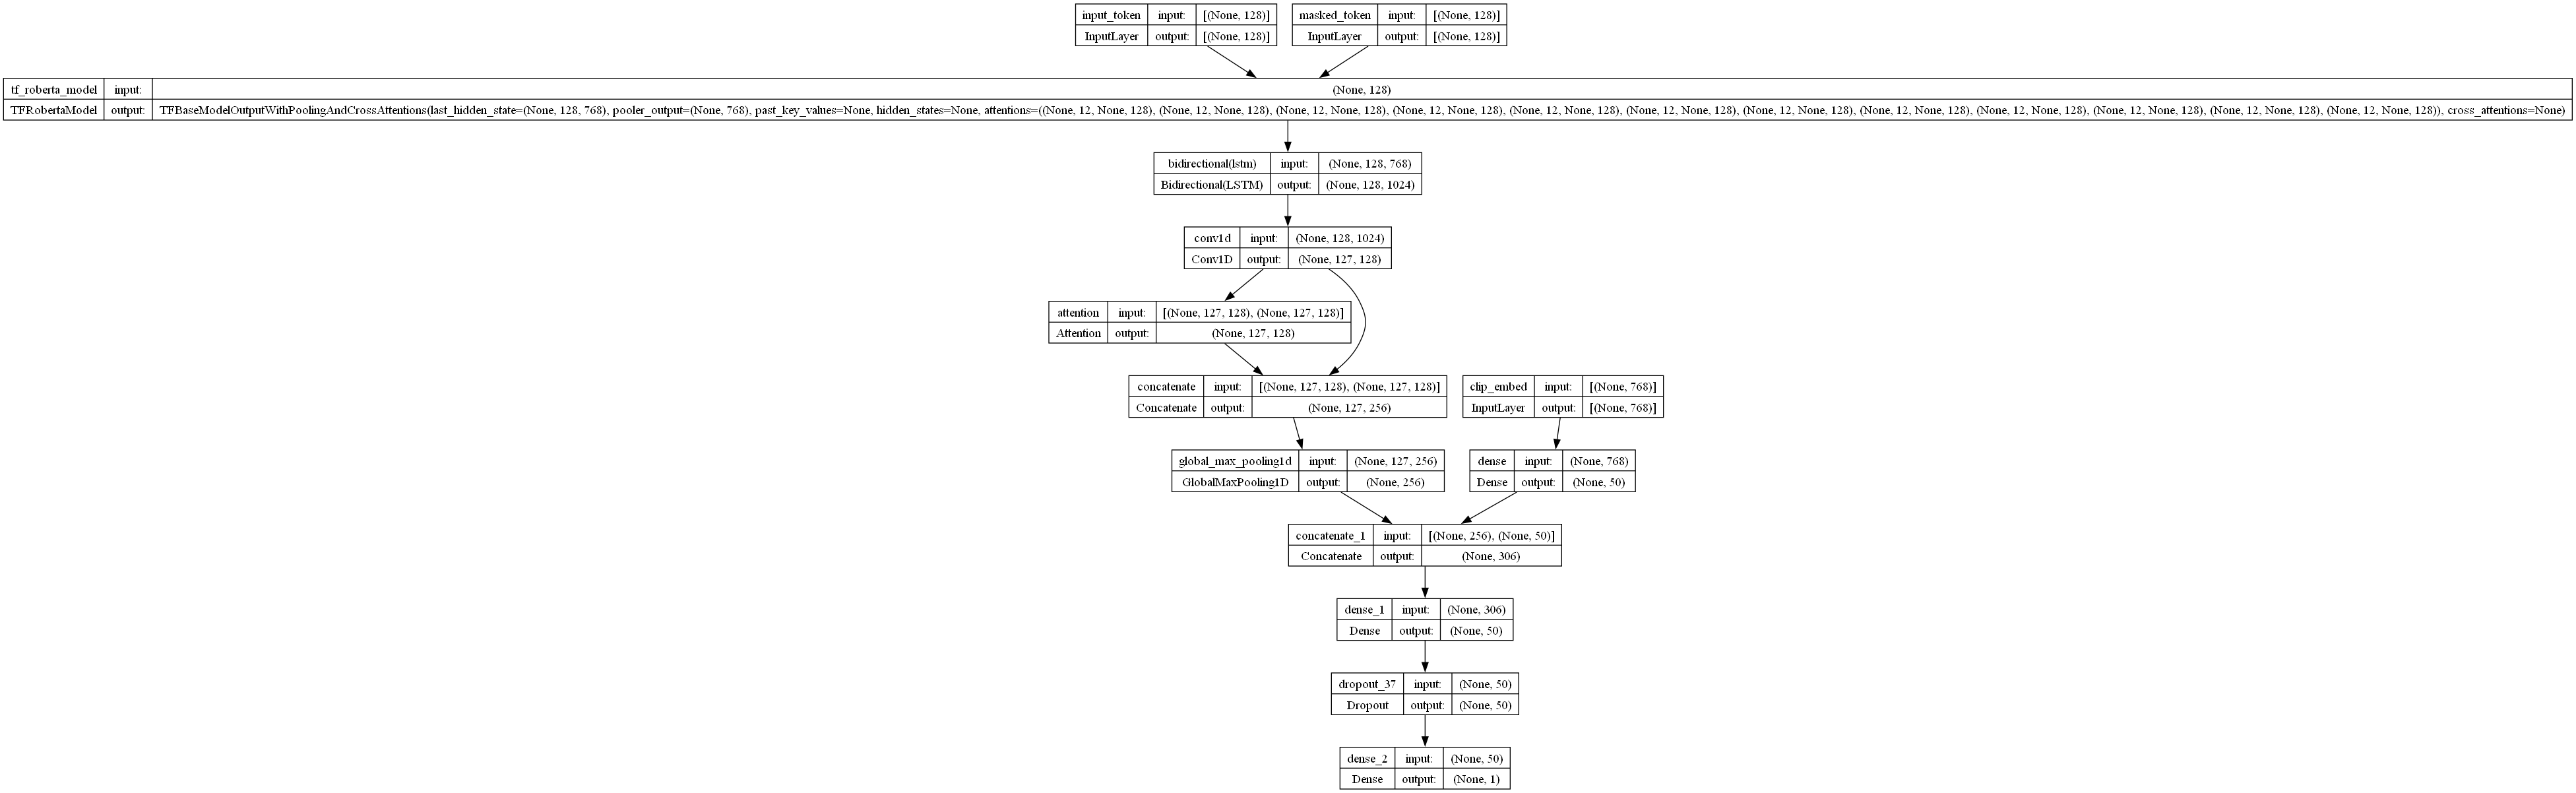

In [3]:
plot_model(model, to_file="clip_svo_roberta.png", show_shapes=True, show_layer_names=True)